# 1.Import Libraries

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime as dt
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools

# 2.Import Datset

In [120]:
airline=pd.read_excel('Airlines+Data.xlsx')
airline.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


# 3.Data Understanding

In [121]:
airline.shape

(96, 2)

In [122]:
airline.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [123]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [124]:
airline.isna().sum()

Month         0
Passengers    0
dtype: int64

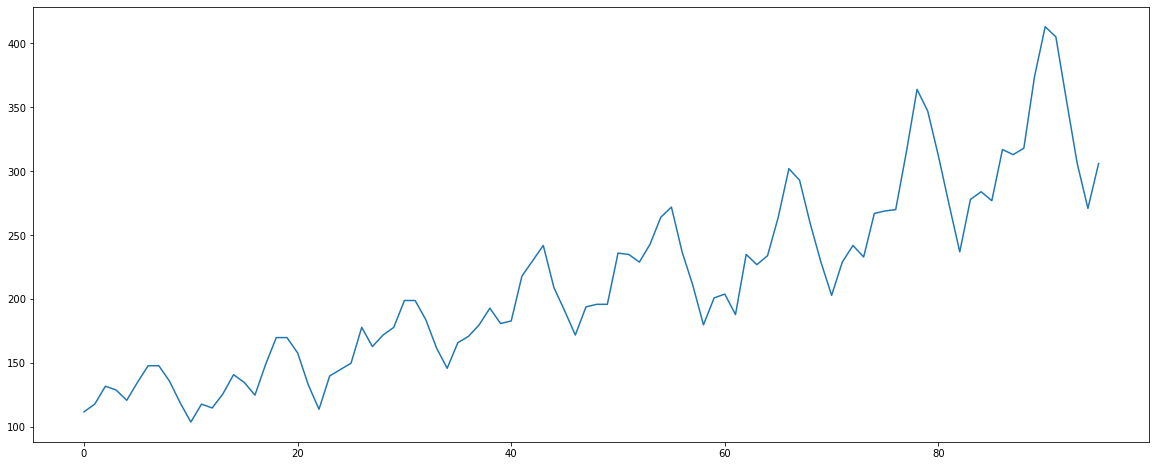

In [125]:
plt.figure(figsize=(20,8))
airline['Passengers'].plot()
plt.show()

#### Here we can see the nature of data is upward trend and multiplicative seasonality

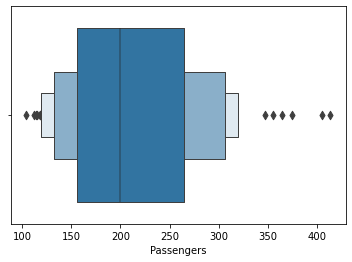

In [126]:
sns.boxenplot(airline['Passengers'])
plt.show()

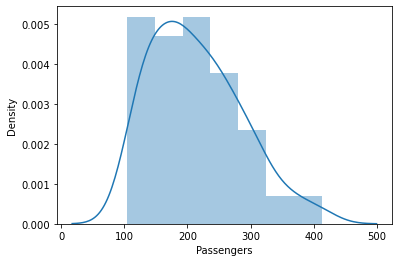

In [127]:
sns.distplot(airline['Passengers'])
plt.show()

# 4.Data Preprocessing

In [128]:
airline['month']=airline['Month'].dt.strftime('%b')
airline.head()

,Month,Passengers,month
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


#### Getting Dummies for Month

In [129]:
dummies=pd.DataFrame(pd.get_dummies(airline['month']))
airline1=pd.concat([airline,dummies],axis=1)
airline1.head()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [130]:
airline1['year']=airline1['Month'].dt.strftime('%y')

In [131]:
airline1["t"] = np.arange(1,97)
airline1["t_squared"] = airline1["t"]*airline1["t"]
airline1["log_Passengers"] = np.log(airline1["Passengers"])
airline1.columns
airline1.head()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,year,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,95,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,95,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,95,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,95,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,95,5,25,4.795791


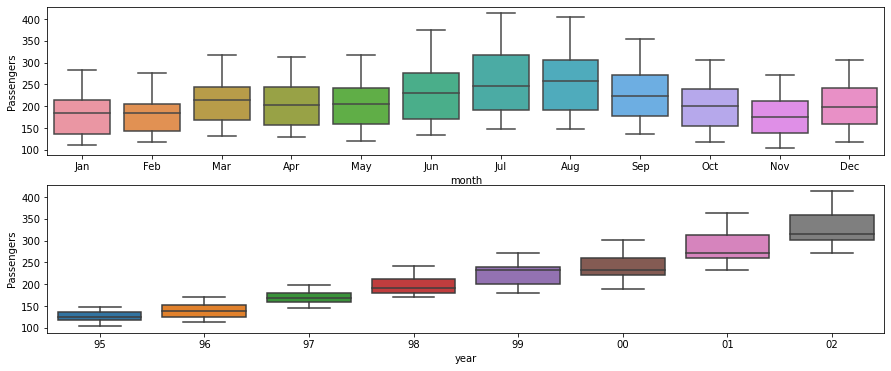

In [132]:
plt.figure(figsize=(15,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=airline1)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=airline1)
plt.show()

<AxesSubplot:xlabel='year', ylabel='Passengers'>

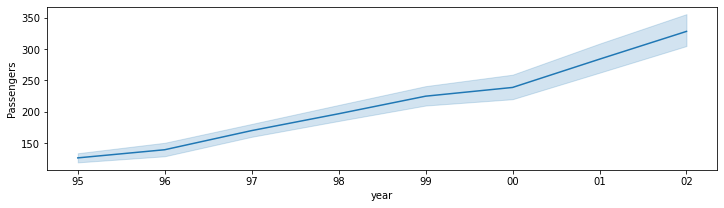

In [133]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=airline1)

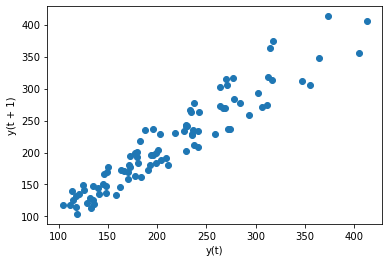

In [134]:
lag_plot(airline1['Passengers'])
plt.show()

# ACF abd PACF plot

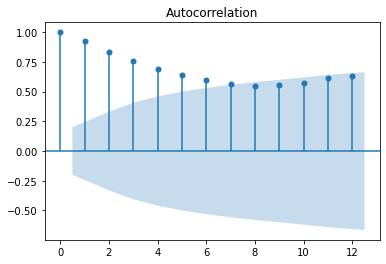

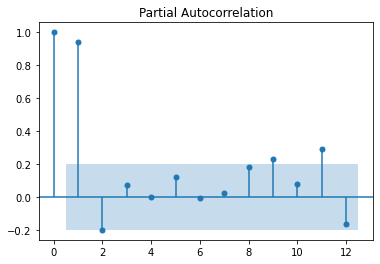

In [135]:
tsa_plots.plot_acf(airline1.Passengers,lags=12)
tsa_plots.plot_pacf(airline1.Passengers,lags=12)
plt.show()

# Time series decomposition plot

<Figure size 2160x720 with 0 Axes>

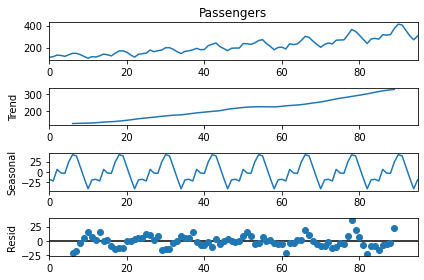

In [136]:
decompose_ts_add = seasonal_decompose(airline1['Passengers'],period=12)
plt.figure(figsize=(30,10))
decompose_ts_add.plot()
plt.show()

#### We have seen decomposition to see how trend and seasonality affecting data

### Splitting data into train and test 

In [137]:
Train = airline1.head(75)
Test = airline1.tail(25)

# 5.Model Building

# 5.1 Model Based Forecasting

## 5.1.1 Linear Model

In [138]:
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  51.83809749584509


## 5.1.2 Exponential model

In [139]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  42.77525975019796


## 5.1.3 Quadratic

In [140]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  54.031406456252654


## 5.1.4 Additive seasonality

In [141]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  123.02763788084238


## 5.1.5 Additive Seasonality Quadratic

In [142]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 36.5362744454732


## 5.1.6 Multiplicative Seasonality

In [143]:
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 128.16622817596155


## 5.1.7 Multiplicative Additive Seasonality

In [144]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 11.565825437686447


# 5.2 Data driven Forecasting

## 5.2.1 Moving Average

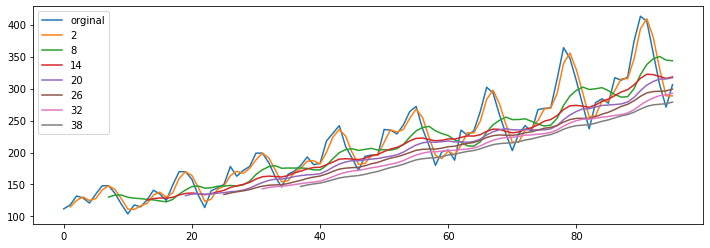

In [145]:
plt.figure(figsize=(12,4))
airline1['Passengers'].plot(label="orginal")
for i in range(2,43,6):
    airline1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [146]:
airline1['Passengers'].rolling(2).mean()

0       NaN
1     115.0
2     125.0
3     130.5
4     125.0
      ...  
91    409.0
92    380.0
93    330.5
94    288.5
95    288.5
Name: Passengers, Length: 96, dtype: float64

## 5.2.2 Simple Exponential Smoothing model

In [147]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])

ses_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_ses))**2))
ses_rms

77.71310757781525

## 5.2.3 Holt model 

In [148]:
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2) # two levels of smoothening
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
hw_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hw))**2))
hw_rms

42.88281154093843

## 5.2.4 Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [149]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])

hw_ma_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hwe_mul_add))**2))
hw_ma_rms

35.717264710840396

## 5.2.5 Holts winter exponential smoothing with additive seasonality and multiplicative trend

In [150]:
hwe_model_add_mul= ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_add_mul = hwe_model_add_mul.predict(start = Test.index[0],end = Test.index[-1])

hw_am_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hwe_add_mul))**2))
hw_am_rms

35.78116614000141

## 5.2.6 Holts winter exponential smoothing with additive seasonality and additive trend

In [151]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])

hw_aa_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hwe_add_add))**2))
hw_aa_rms

40.85889167377492

## 5.2.7 ARMA Model

In [152]:
ARMAmodel = ARMA(Train['Passengers'], order=(3, 0)) #model with AR=1 and MA=0
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(start = Test.index[0],end = Test.index[-1])
ARMA_pred

arma_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(ARMA_pred))**2))
arma_rms

95.18037149843077

## 5.2.7 ARIMA Model

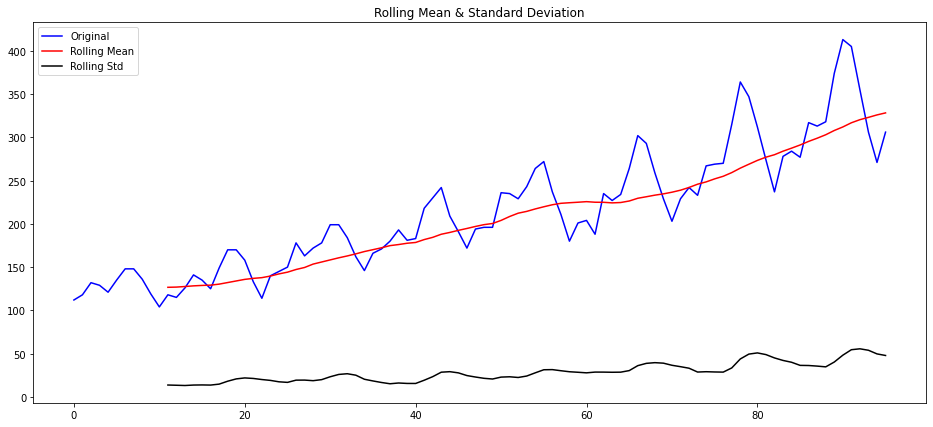

In [153]:
rolLmean = airline1['Passengers'].rolling(12).mean() # 12 entries
rolLstd = airline1['Passengers'].rolling(12).std()

plt.figure(figsize=(16,7))

#Plot rolling statistics:
orig = plt.plot(airline1['Passengers'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### We can see that data is not stationery 

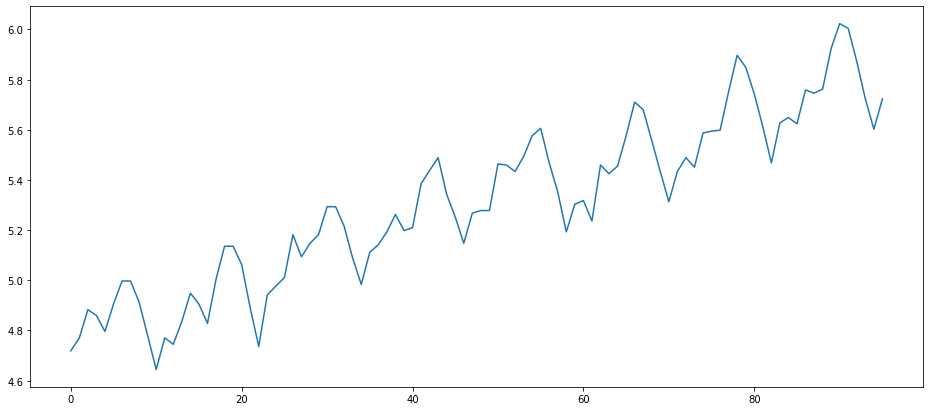

In [154]:
plt.figure(figsize=(16,7))
ts_log = np.log(airline1['Passengers'])#to transform to stationary from non-stationary
plt.plot(ts_log)

### Differencing

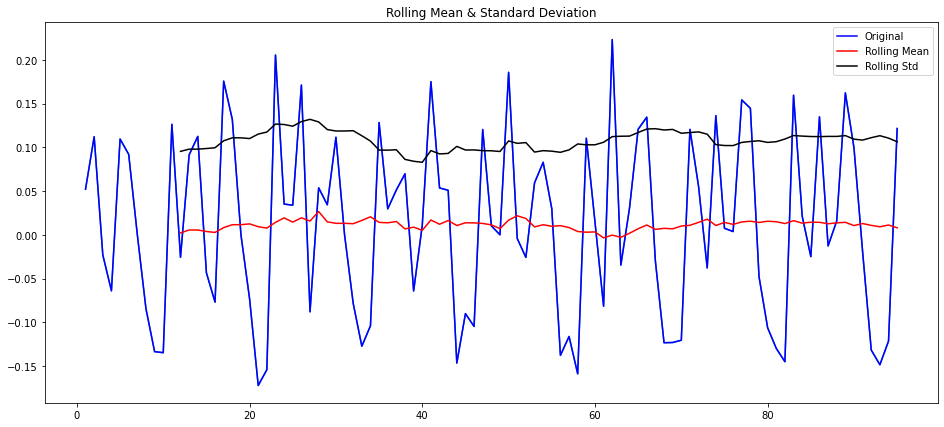

In [155]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift(periods=1) # I will shift the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [156]:
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

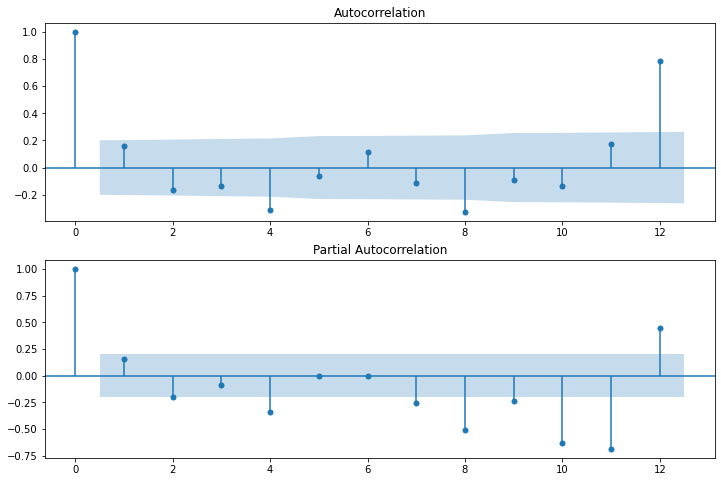

In [157]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=12,ax=ax2)

In [158]:
p = range(0,5) #AR order
d = range(0,5) #Shift
q = range(0,5) #MA order
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [162]:
for param in pdq:
    try:
        model_arima = ARIMA(Train['Passengers'],order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 798.104902226917
(0, 0, 1) 724.8324368557174
(0, 0, 2) 697.6310130673377
(0, 0, 3) 674.477226610447
(0, 0, 4) 679.1096596119293
(0, 1, 0) 651.0060495265144
(0, 1, 1) 650.3890900159124
(0, 1, 2) 642.4408351367733
(0, 1, 3) 639.3423999697375
(0, 1, 4) 634.9655458542916
(0, 2, 0) 679.8429925078271
(0, 2, 1) 649.5527653814654
(0, 2, 2) 648.5549411766843
(0, 2, 3) 648.7978375790595
(0, 2, 4) 642.3167946758142
(1, 0, 0) 662.8306222482382
(1, 0, 1) 660.8678653816227
(1, 0, 2) 662.23240970985
(1, 0, 3) 1072.2441384835581
(1, 0, 4) 756.0725449197672
(1, 1, 0) 651.1485682612251
(1, 1, 1) 644.0827563029886
(1, 1, 2) 637.3137332960176
(1, 1, 3) 639.076310641859
(1, 1, 4) 636.5061077055072
(1, 2, 0) 674.7301662654532
(1, 2, 1) 649.3515096186235
(1, 2, 2) 647.9629007542999
(1, 2, 3) 649.606653434026
(1, 2, 4) 651.3040306118216
(2, 0, 0) 661.6510822606604
(2, 0, 1) 661.0257060533089
(2, 0, 2) 662.4573487479603
(2, 0, 4) 735.9780249892202
(2, 1, 0) 650.7769340850984
(2, 1, 1) 634.48786395004

### (4,1,3) gives least aic value

In [163]:
ARIMAmodel = ARIMA(Train['Passengers'], order=(4, 1, 3)) #notice p,d and q value here
ARIMA_model_fit = ARIMAmodel.fit()

ARIMA_pred = ARIMA_model_fit.predict(1,12,typ='levels')

arima_rms=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(ARMA_pred))**2))
arima_rms

95.18037149843077

In [164]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea","ses_model","hw_model","hwe_model_mul_add","hwe_model_add_mul","hwe_model_add_add","ARMAmodel","ARIMAmodel"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea,ses_rms,hw_rms,hw_ma_rms,hw_am_rms,hw_aa_rms,arma_rms,arima_rms])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,51.838097
1,rmse_Exp,42.775260
2,rmse_Quad,54.031406
3,rmse_add_sea,123.027638
4,rmse_add_sea_quad,36.536274
5,rmse_Mult_sea,128.166228
6,rmse_Mult_add_sea,11.565825
7,ses_model,77.713108
8,hw_model,42.882812
9,hwe_model_mul_add,35.717265


### We can clearly see that Multiplicative Additive Seasonality gave less RMSE value